In [1]:
from astropy.table import Table

import numpy as np

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB

import matplotlib.pyplot as plt
%matplotlib notebook
#plt.rcParams.update({'font.size': 22})

In [2]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

q0 = 0.2

# Data

In [3]:
#data_filename = '/Users/kellydouglass/Desktop/Pipe3D-master_file_vflag_10_smooth2p27_N2O2_noWords.txt'
data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v6.txt'

data = Table.read(data_filename, format='ascii.commented_header')

## $V_{max}$ of best fit

Deprecated with fitting the entire velocity map

In [4]:
'''
good_galaxies['v_max'] = -1.
#good_galaxies['v_max'].unit = 'km / s'

for i in range(len(good_galaxies)):
    curve = good_galaxies['curve_used'][i]
    
    #if curve != 'non' and curve != 'none':
    if curve == -1:
        good_galaxies['v_max'][i] = good_galaxies['neg_v_max'][i]
    elif curve == 0:
        good_galaxies['v_max'][i] = good_galaxies['avg_v_max'][i]
    elif curve == 1:
        good_galaxies['v_max'][i] = good_galaxies['pos_v_max'][i]
''';

## Calculate the velocity at $R_{90}$, $R_{max}$

In [5]:
################################################################################
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
dist_to_galaxy_Mpc = c*data['NSA_redshift']/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

data['R90_kpc'] = dist_to_galaxy_kpc*np.tan(data['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

data['V90_kms'] = rot_fit_BB(data['R90_kpc'], 
                             [data['Vmax_map'], 
                              data['Rturn_map'], 
                              data['alpha_map']])

data['VRmax_kms'] = rot_fit_BB(data['Rmax_map'], 
                               [data['Vmax_map'], 
                                data['Rturn_map'], 
                                data['alpha_map']])

/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


In [6]:
data['M90_Mdisk_ratio'] = 10**(data['M90_map'] - data['M90_disk_map'])

data['M90_MdiskHI_ratio'] = 10**data['M90_map']/(10**data['M90_disk_map'] + 10**data['logHI'])

data['M90_vis'] = np.log10(10**data['M90_disk_map'] + 10**data['logHI'])

In [7]:
# Correct the HI line width (Eqn. 3 from Masters14)
dv = 5.15 # km/s
dt = 6.5  # km/s
lam = 0.3 # Should really be calculated

cosi2 = (data['ba_map']**2 - q0**2)/(1 - q0**2)
cosi2[cosi2 < 0] = 0

data['WF50_corrected'] = ((data['WF50'] - 2*dv*lam)/(1 + data['NSA_redshift']) - dt)/np.sqrt(1 - cosi2)

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_3785/2298607351.py:9: RuntimeWarning: divide by zero encountered in true_divide
  data['WF50_corrected'] = ((data['WF50'] - 2*dv*lam)/(1 + data['NSA_redshift']) - dt)/np.sqrt(1 - cosi2)


In [8]:
bad_boolean = np.logical_or.reduce([np.isnan(data['M90_map']), 
                                    np.isnan(data['M90_disk_map']), 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998, 
                                    data['V90_kms']/data['Vmax_map'] < 0.9, 
                                    (data['Tidal'] & (data['DL_merge'] > 0.97)), 
                                    data['map_frac_unmasked'] < 0.05, 
                                    (data['map_frac_unmasked'] > 0.13) & (data['DRP_map_smoothness'] > 1.96), 
                                    (data['map_frac_unmasked'] > 0.07) & (data['DRP_map_smoothness'] > 2.9), 
                                    (data['map_frac_unmasked'] > -0.0638*data['DRP_map_smoothness'] + 0.255) & (data['DRP_map_smoothness'] > 1.96), 
                                    data['M90_Mdisk_ratio'] > 1050])

good_galaxies = data[~bad_boolean]

'''
bad_boolean = np.logical_or.reduce([data['M90_map'] == -99, 
                                    data['M90_disk_map'] == -99, 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998])

good_galaxies = data[~bad_boolean]
'''
print(len(good_galaxies))

1988


## Pull out those objects with good HI observations

In [9]:
#HI_boolean = np.logical_or(good_galaxies['logHI'] == -99, good_galaxies['logHI'] == -999)
HI_boolean = np.logical_or(np.isnan(good_galaxies['logHI']), 
                           good_galaxies['logHI'] == -999)

goodHI_galaxies = good_galaxies[~HI_boolean]

print(len(goodHI_galaxies))

844


## Split by environment

In [10]:
vboolean = good_galaxies['vflag'] == 1
wboolean = good_galaxies['vflag'] == 0

void_table = good_galaxies[vboolean]
wall_table = good_galaxies[wboolean]
edge_table = good_galaxies[np.logical_not(np.logical_or(vboolean, wboolean))]

## Split by CMD classification

In [11]:
BC_boolean = good_galaxies['CMD_class'] == 1
GV_boolean = good_galaxies['CMD_class'] == 2
RS_boolean = good_galaxies['CMD_class'] == 3

BC = good_galaxies[BC_boolean]
GV = good_galaxies[GV_boolean]
RS = good_galaxies[RS_boolean]

print('Blue cloud:', len(BC), np.sum(BC['M90_Mdisk_ratio'] < 20))
print('Green valley:', len(GV), np.sum(GV['M90_Mdisk_ratio'] < 20))
print('Red sequence:', len(RS), np.sum(RS['M90_Mdisk_ratio'] < 20))

Blue cloud: 928 818
Green valley: 492 423
Red sequence: 388 319


In [12]:
BC_HI_boolean = goodHI_galaxies['CMD_class'] == 1
GV_HI_boolean = goodHI_galaxies['CMD_class'] == 2
RS_HI_boolean = goodHI_galaxies['CMD_class'] == 3

BC_HI = goodHI_galaxies[BC_HI_boolean]
GV_HI = goodHI_galaxies[GV_HI_boolean]
RS_HI = goodHI_galaxies[RS_HI_boolean]

print('Blue cloud:', len(BC_HI))
print('Green valley:', len(GV_HI))
print('Red sequence:', len(RS_HI))

Blue cloud: 528
Green valley: 151
Red sequence: 76


# Tully-Fisher relations

##### Traditional (luminosity v. $V_{max}$)

<IPython.core.display.Javascript object>


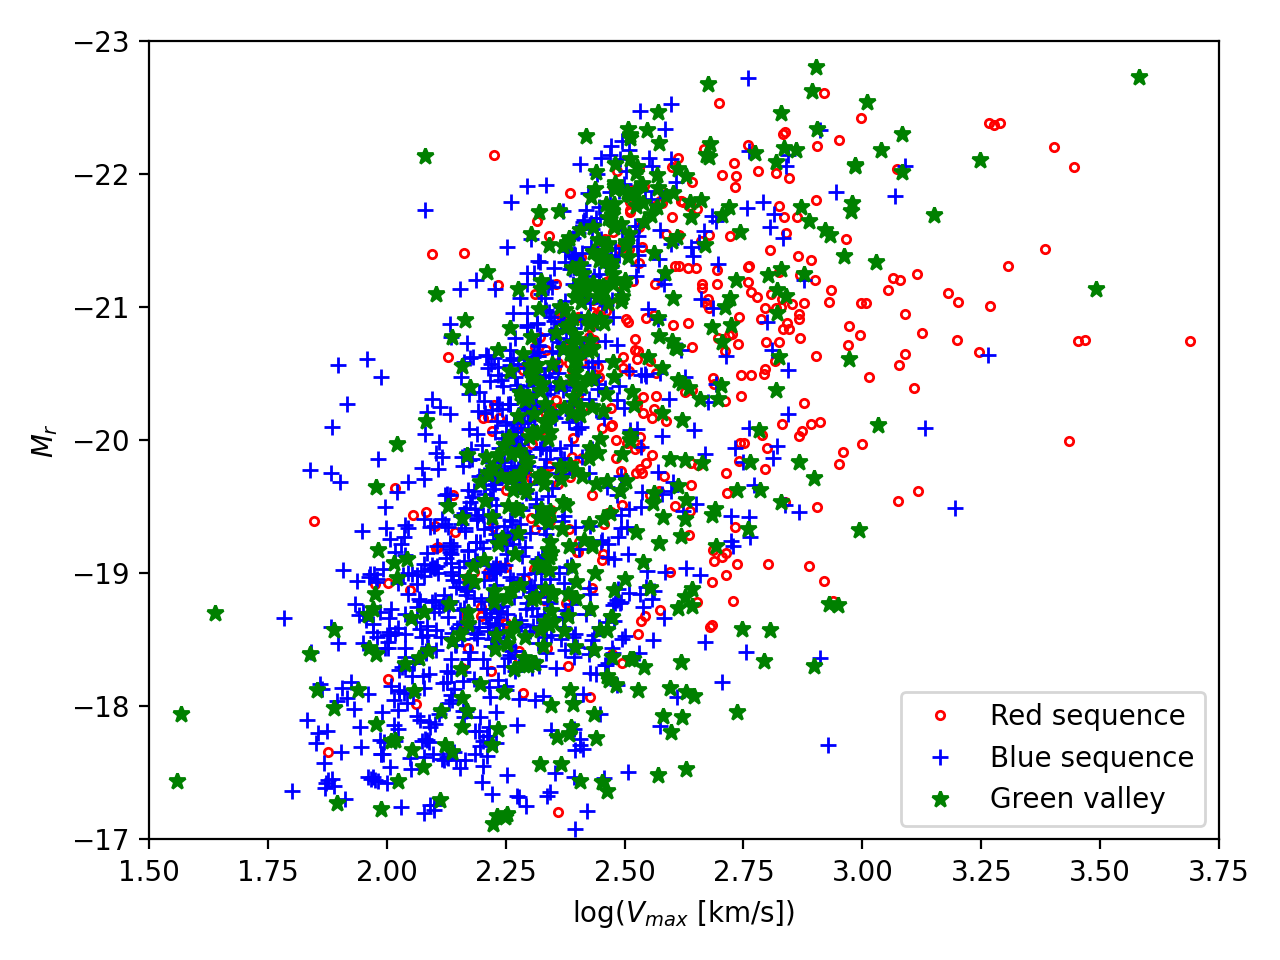

In [13]:
fig = plt.figure(tight_layout=True)

plt.errorbar(np.log10(RS['Vmax_map']), 
             RS['rabsmag'], 
             #yerr=RS['Vmax_err_map'], 
             fmt='r.', 
             fillstyle='none', 
             label='Red sequence')

plt.errorbar(np.log10(BC['Vmax_map']), 
             BC['rabsmag'], 
             #yerr=BC['Vmax_err_map'], 
             fmt='b+', 
             label='Blue sequence')

plt.errorbar(np.log10(GV['Vmax_map']), 
             GV['rabsmag'], 
             #yerr=GV['Vmax_err_map'], 
             fmt='g*', 
             label='Green valley')

plt.ylim((-17,-23))
plt.xlim((1.5, 3.75))

plt.ylabel('$M_r$')
plt.xlabel('log($V_{max}$ [km/s])')

plt.legend();

##### Baryonic ($M_*$ v. $V_{max}$)

Include best-fits from other papers

In [23]:
logM = np.arange(8,13,1)
v = np.logspace(1.5,3.75,20)

AvilaReese08 = -0.650 + 0.274*logM

#Ferrero17 = -0.86 + 0.30*logM
Ferrero17_M = 8.63e8*((v/50)**4.1)*np.exp(-(v/50)**0.432)

#AquinoOrtiz18 = -0.63 + 0.27*logM # gas TF of just spirals
AquinoOrtiz18 = -0.41 + 0.25*logM # gas TF

AquinoOrtiz20 = -1.17 + 0.31*logM

<IPython.core.display.Javascript object>


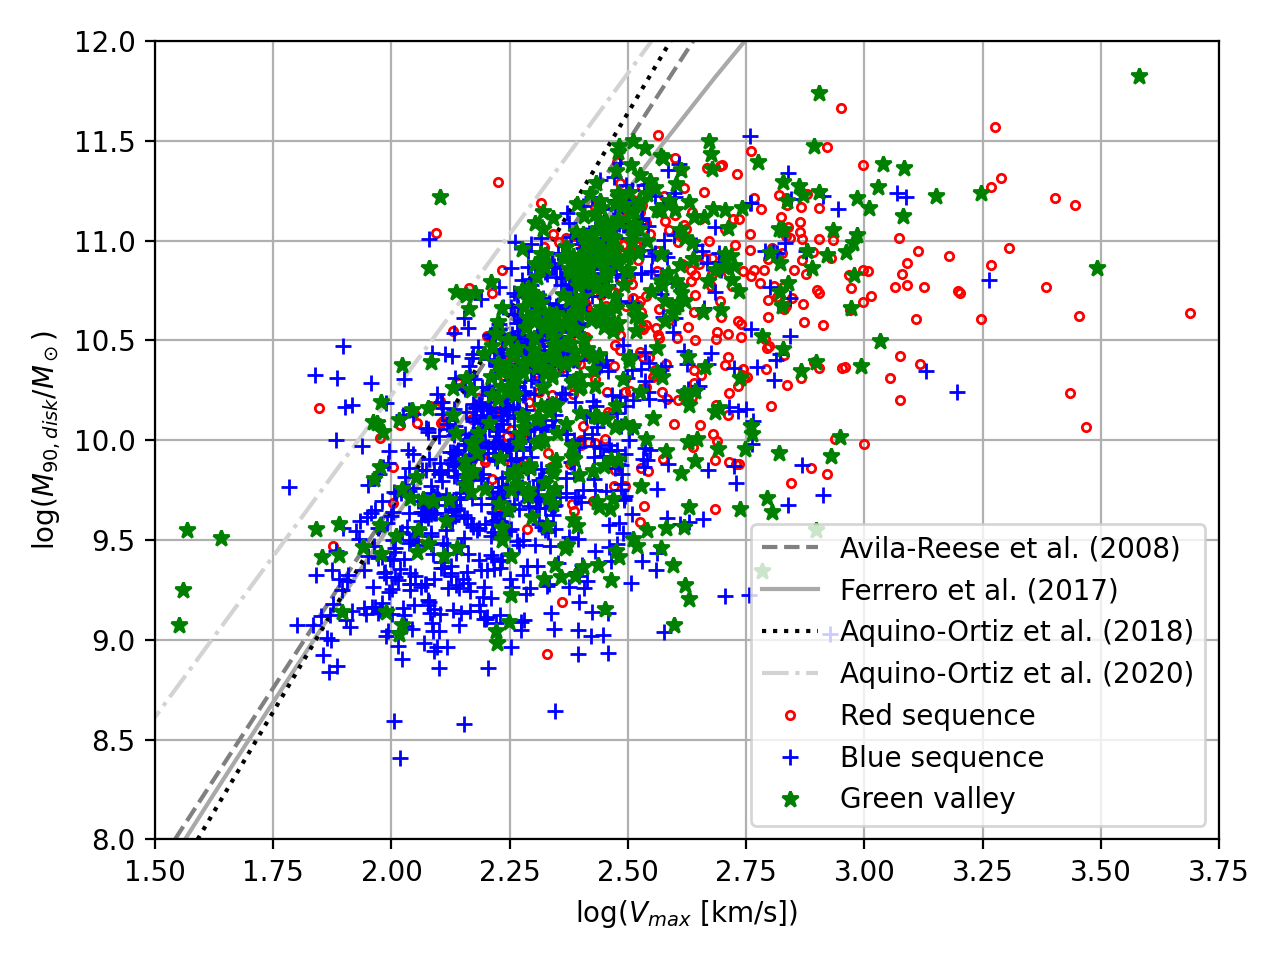

In [24]:
fig = plt.figure(tight_layout=True)

plt.errorbar(np.log10(RS['Vmax_map']), 
             RS['M90_disk_map'], 
             #xerr=RS['Vmax_err_map'], 
             fmt='r.', 
             fillstyle='none', 
             label='Red sequence')

plt.errorbar(np.log10(BC['Vmax_map']), 
             BC['M90_disk_map'], 
             #xerr=BC['Vmax_err_map'], 
             fmt='b+', 
             label='Blue sequence')

plt.errorbar(np.log10(GV['Vmax_map']), 
             GV['M90_disk_map'], 
             #xerr=GV['Vmax_err_map'], 
             fmt='g*', 
             label='Green valley')

plt.plot(AvilaReese08, logM, '--', c='gray', label='Avila-Reese et al. (2008)')
#plt.plot([1.8, 2.6], [9.1, 11.9], 'r--', label='Avila-Reese et al. (2008)')

#plt.plot(Ferrero17, logM, c='darkgray', label='Ferrero et al. (2017)')
plt.plot(np.log10(v), np.log10(Ferrero17_M),
         c='darkgray', 
         label='Ferrero et al. (2017)')

plt.plot(AquinoOrtiz18, logM, 'k:', label='Aquino-Ortiz et al. (2018)')

plt.plot(AquinoOrtiz20, logM, '-.', c='lightgray', label='Aquino-Ortiz et al. (2020)')
#plt.plot([1.7, 2.6], [9.1, 11.9], '-.', c='purple', label='Aquino-Ortiz et al. (2020)')

plt.grid()

plt.ylim((8,12))
plt.xlim((1.5, 3.75))

plt.ylabel(r'log($M_{90,disk}/M_\odot$)')
plt.xlabel('log($V_{max}$ [km/s])')

plt.legend();

What is the residual between our fitted $V_{max}$ and that predicted by Aquino-Ortiz et al. (2020)?

In [16]:
BC_AO20_residual = BC['Vmax_map'] - 10**(-1.17 + 0.31*BC['M90_disk_map'])
GV_AO20_residual = GV['Vmax_map'] - 10**(-1.17 + 0.31*GV['M90_disk_map'])
RS_AO20_residual = RS['Vmax_map'] - 10**(-1.17 + 0.31*RS['M90_disk_map'])

<IPython.core.display.Javascript object>


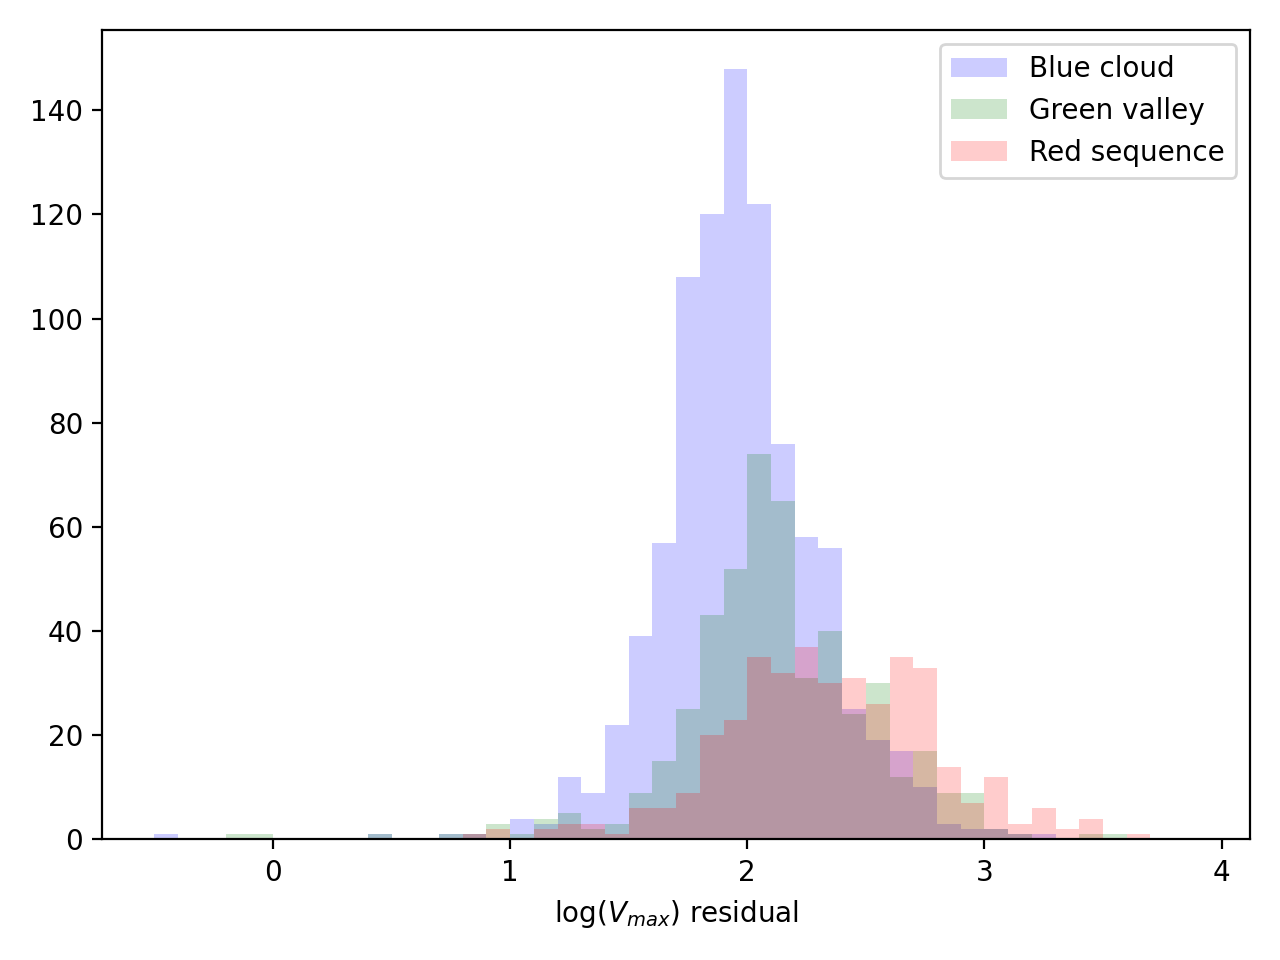

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_29686/2168252243.py:5: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(BC_AO20_residual), bins=residual_bins, color='b', alpha=0.2, label='Blue cloud')
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_29686/2168252243.py:6: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(GV_AO20_residual), bins=residual_bins, color='g', alpha=0.2, label='Green valley')
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_29686/2168252243.py:7: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(RS_AO20_residual), bins=residual_bins, color='r', alpha=0.2, label='Red sequence')


In [17]:
plt.figure(tight_layout=True)

residual_bins = np.arange(-0.5, 4, 0.1)

plt.hist(np.log10(BC_AO20_residual), bins=residual_bins, color='b', alpha=0.2, label='Blue cloud')
plt.hist(np.log10(GV_AO20_residual), bins=residual_bins, color='g', alpha=0.2, label='Green valley')
plt.hist(np.log10(RS_AO20_residual), bins=residual_bins, color='r', alpha=0.2, label='Red sequence')

plt.xlabel('log($V_{max}$) residual')

plt.legend();

Does our data match if we use $M_*$ from the NSA?

<IPython.core.display.Javascript object>


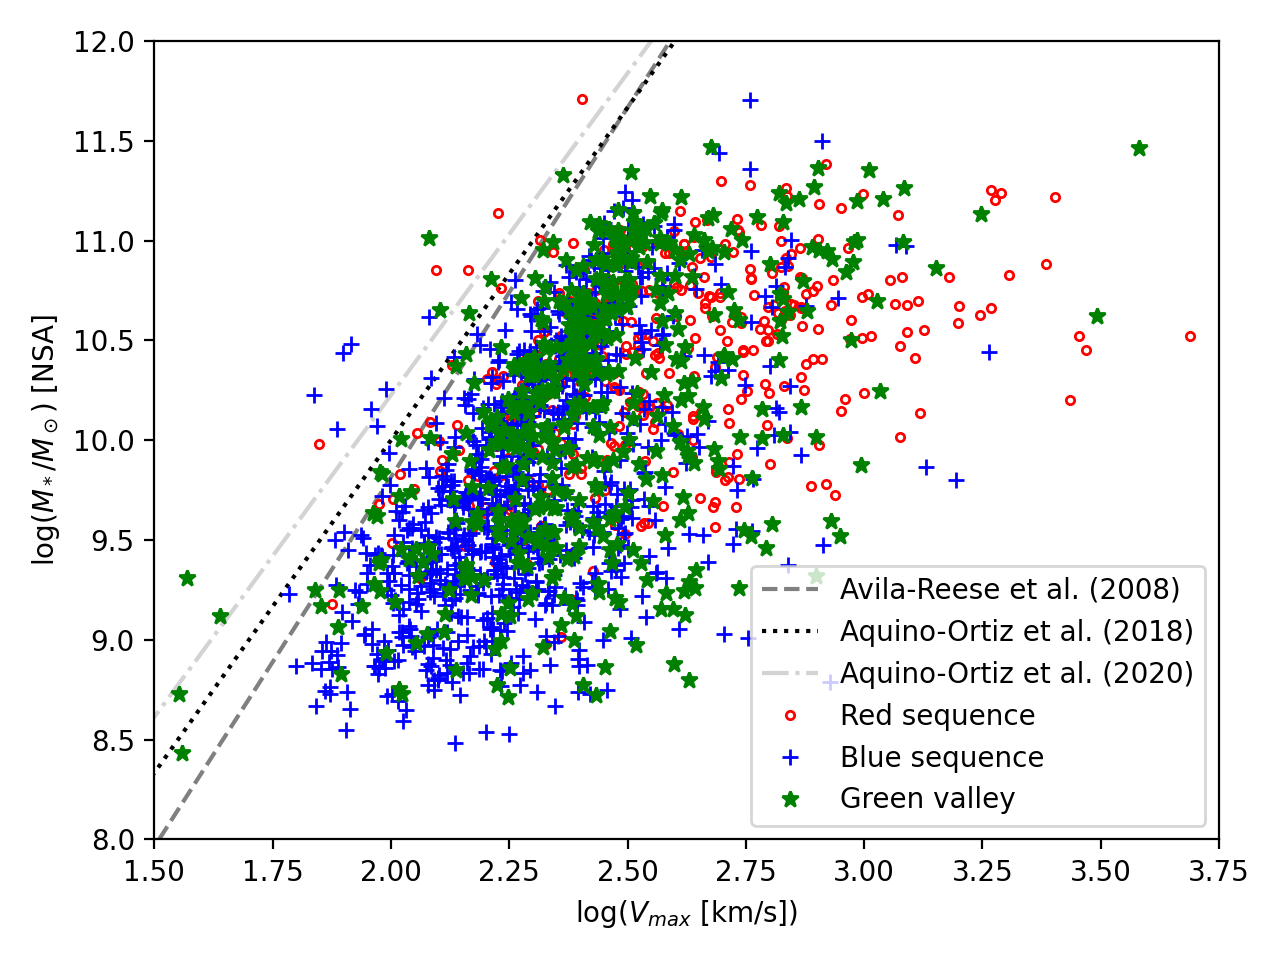

In [18]:
fig = plt.figure(tight_layout=True)

plt.errorbar(np.log10(RS['Vmax_map']), 
             np.log10(RS['NSA_Mstar']), 
             #xerr=RS['Vmax_err_map'], 
             fmt='r.', 
             fillstyle='none', 
             label='Red sequence')

plt.errorbar(np.log10(BC['Vmax_map']), 
             np.log10(BC['NSA_Mstar']), 
             #xerr=BC['Vmax_err_map'], 
             fmt='b+', 
             label='Blue sequence')

plt.errorbar(np.log10(GV['Vmax_map']), 
             np.log10(GV['NSA_Mstar']), 
             #xerr=GV['Vmax_err_map'], 
             fmt='g*', 
             label='Green valley')

plt.plot(AvilaReese08, logM, '--', c='gray', label='Avila-Reese et al. (2008)')

plt.plot(AquinoOrtiz18, logM, 'k:', label='Aquino-Ortiz et al. (2018)')

plt.plot(AquinoOrtiz20, logM, '-.', c='lightgray', label='Aquino-Ortiz et al. (2020)')

plt.ylim((8,12))
plt.xlim((1.5, 3.75))

plt.ylabel(r'log($M_*/M_\odot$) [NSA]')
plt.xlabel('log($V_{max}$ [km/s])')

plt.legend();

How does it look if we use the HI line width?

First, how does $V_{max}$ compare with the HI line width?

<IPython.core.display.Javascript object>


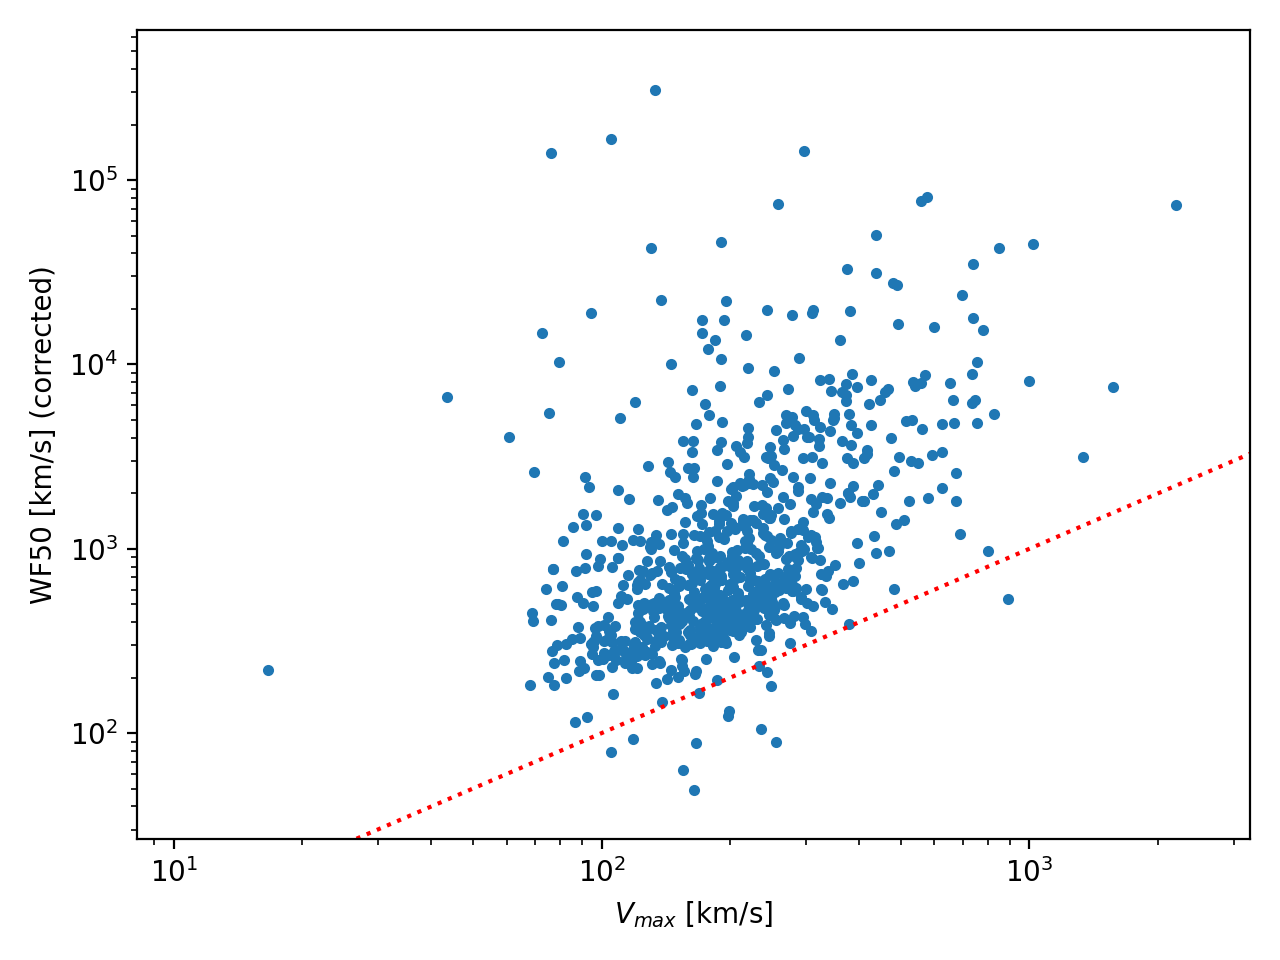

In [21]:
plt.figure(tight_layout=True)

plt.loglog(goodHI_galaxies['Vmax_map'], goodHI_galaxies['WF50_corrected'], '.')

plt.plot([1,3e6], [1,3e6], 'r:')

plt.xlabel('$V_{max}$ [km/s]')
plt.ylabel('WF50 [km/s] (corrected)');

Does it fit better when fitting to the Pipe3D stellar velocity maps?

In [22]:
P3D_fit_filename = '../spirals/Pipe3D_starVel_map_results_BB_v1.fits'

P3D_fits = Table.read(P3D_fit_filename, format='fits')

<IPython.core.display.Javascript object>


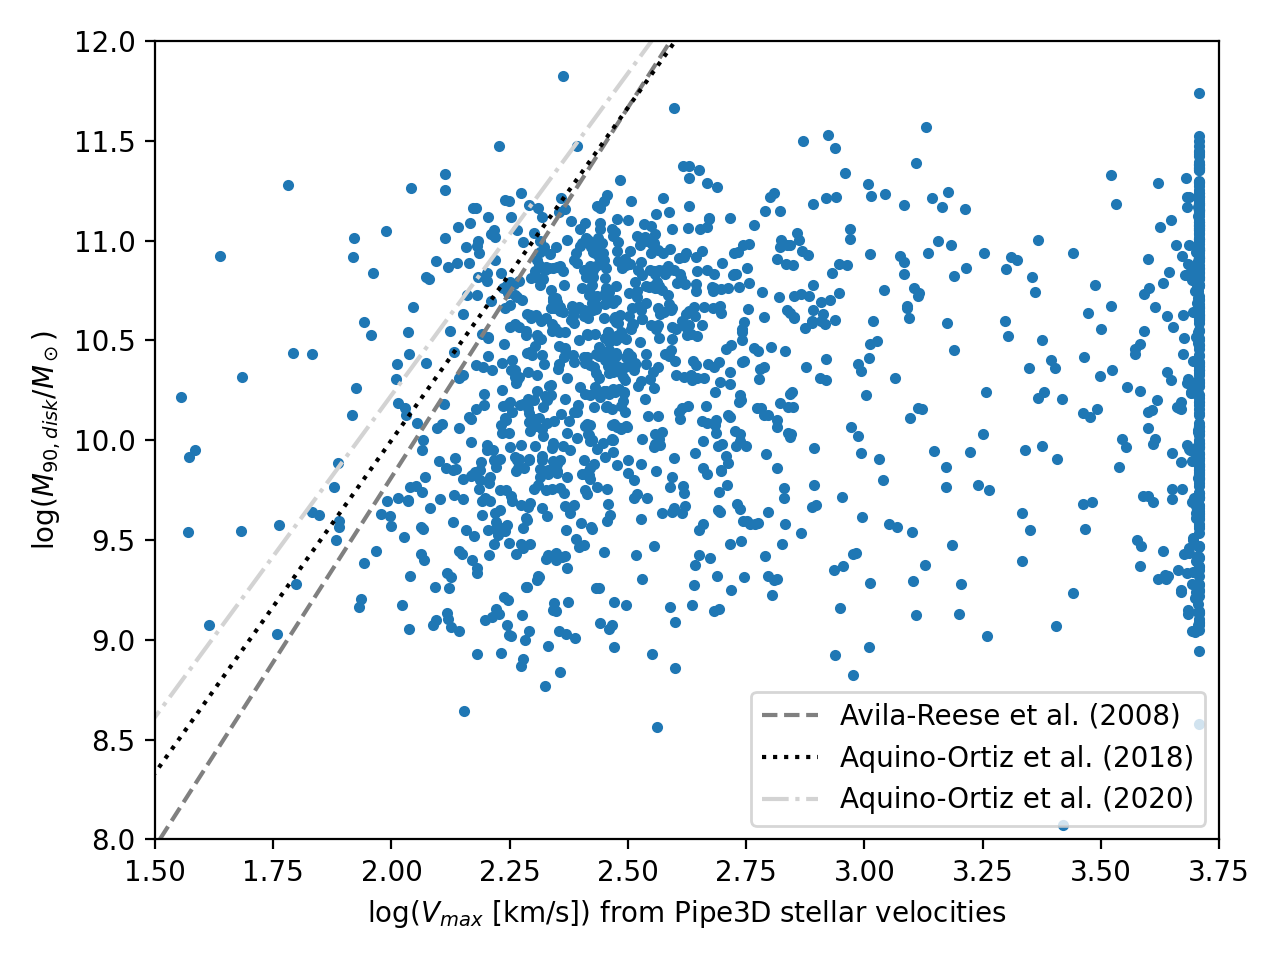

In [23]:
fig = plt.figure(tight_layout=True)

plt.plot(np.log10(P3D_fits['v_max_star']), 
         P3D_fits['M90_disk_map'], 
         '.')

plt.plot(AvilaReese08, logM, '--', c='gray', label='Avila-Reese et al. (2008)')

plt.plot(AquinoOrtiz18, logM, 'k:', label='Aquino-Ortiz et al. (2018)')

plt.plot(AquinoOrtiz20, logM, '-.', c='lightgray', label='Aquino-Ortiz et al. (2020)')

plt.ylim((8,12))
plt.xlim((1.5, 3.75))

plt.ylabel(r'log($M_{90,disk}/M_\odot$)')
plt.xlabel('log($V_{max}$ [km/s]) from Pipe3D stellar velocities')

plt.legend();

Do our results match better when using $V(R_{90})$ instead of $V_{max}$?

<IPython.core.display.Javascript object>


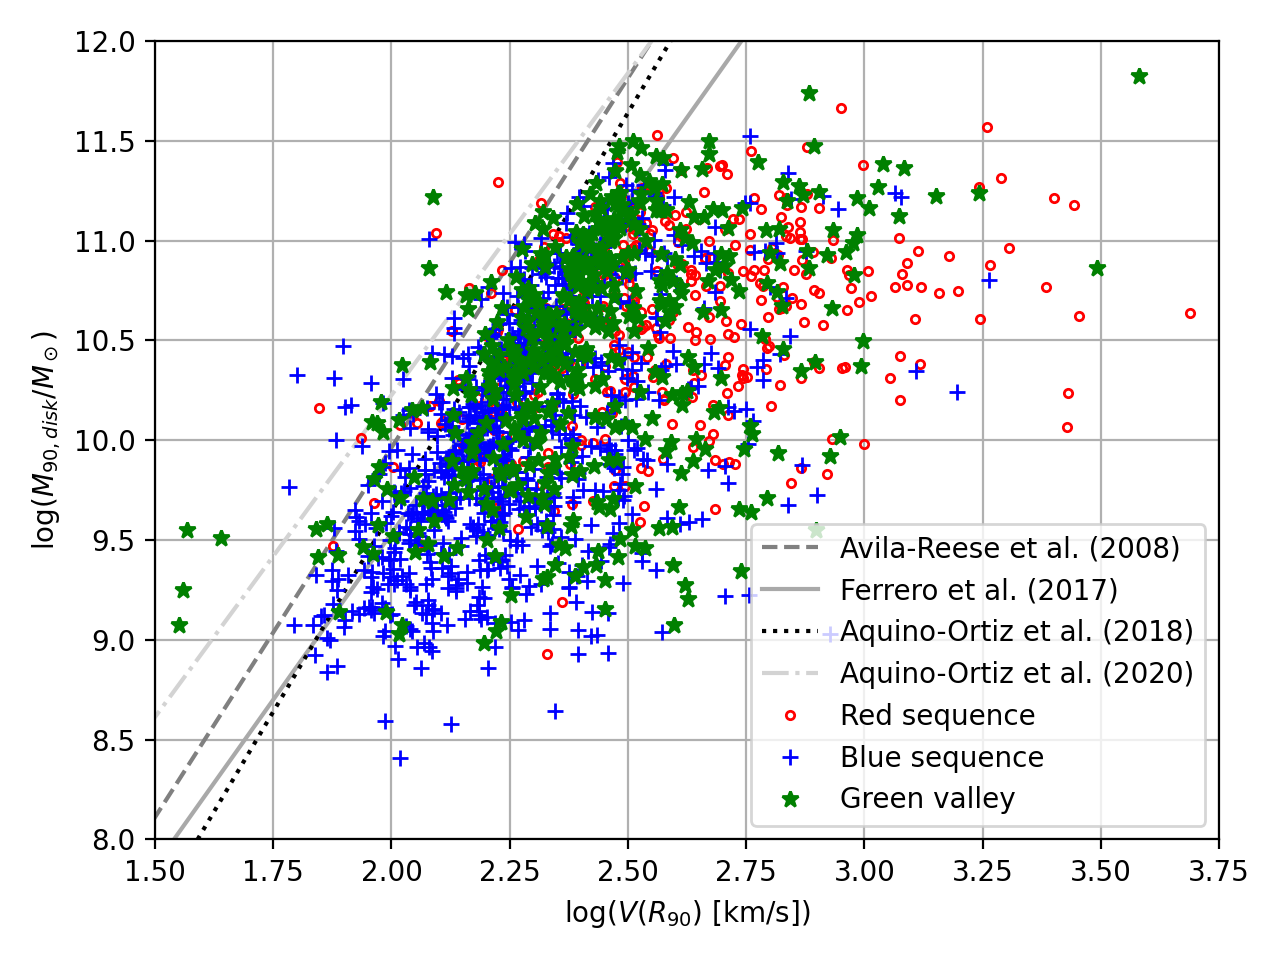

In [19]:
fig = plt.figure(tight_layout=True)

plt.errorbar(np.log10(RS['V90_kms']), 
             RS['M90_disk_map'], 
             #xerr=RS['Vmax_err_map'], 
             fmt='r.', 
             fillstyle='none', 
             label='Red sequence')

plt.errorbar(np.log10(BC['V90_kms']), 
             BC['M90_disk_map'], 
             #xerr=BC['Vmax_err_map'], 
             fmt='b+', 
             label='Blue sequence')

plt.errorbar(np.log10(GV['V90_kms']), 
             GV['M90_disk_map'], 
             #xerr=GV['Vmax_err_map'], 
             fmt='g*', 
             label='Green valley')

plt.plot(AvilaReese08, logM, '--', c='gray', label='Avila-Reese et al. (2008)')
#plt.plot([1.8, 2.6], [9.1, 11.9], 'r--', label='Avila-Reese et al. (2008)')

plt.plot(Ferrero17, logM, c='darkgray', label='Ferrero et al. (2017)')

plt.plot(AquinoOrtiz18, logM, 'k:', label='Aquino-Ortiz et al. (2018)')

plt.plot(AquinoOrtiz20, logM, '-.', c='lightgray', label='Aquino-Ortiz et al. (2020)')
#plt.plot([1.7, 2.6], [9.1, 11.9], '-.', c='purple', label='Aquino-Ortiz et al. (2020)')

plt.grid()

plt.ylim((8,12))
plt.xlim((1.5, 3.75))

plt.ylabel(r'log($M_{90,disk}/M_\odot$)')
plt.xlabel('log($V(R_{90})$ [km/s])')

plt.legend();